In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/11

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/11


In [0]:
import tensorflow.keras 
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름. (?) 
# 내생각) 그냥 학습을 반드시 이렇게해야함. 음수가 나올수도 있기 때문. // log를 안쓰면 코딩이 복잡할거 같은데..
# log를 안써도 됨. 

In [0]:
z_mean

<tf.Tensor 'dense_1/Identity:0' shape=(None, 2) dtype=float32>

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가(노드각각이) N(mu,sigma) 이 되도록 parameter(beta)가 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

In [0]:
k.int_shape(z_mean)[1]

2

In [0]:
k.random_normal(shape=(2,5)) # univariate standard normal dist. 에서 2x5개 난수 생성 (결과 형태가 2x5)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-1.1307969 ,  0.7069995 , -0.38757426, -0.52838635, -1.4398613 ],
       [-0.2922386 , -0.6368236 ,  0.21285442, -1.1786522 ,  0.54219806]],
      dtype=float32)>

In [0]:
z_log_var

<tf.Tensor 'dense_2/Identity:0' shape=(None, 2) dtype=float32>

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
______________________________________________________________________________________________

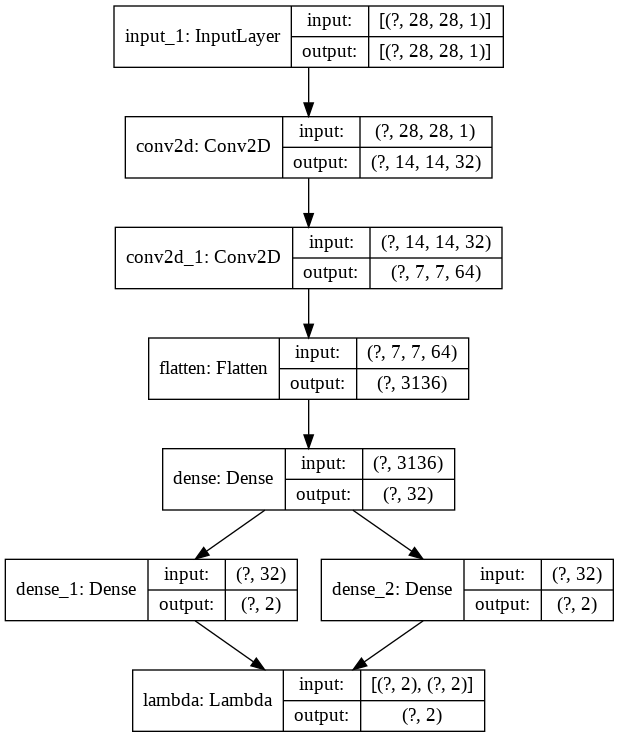

In [0]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

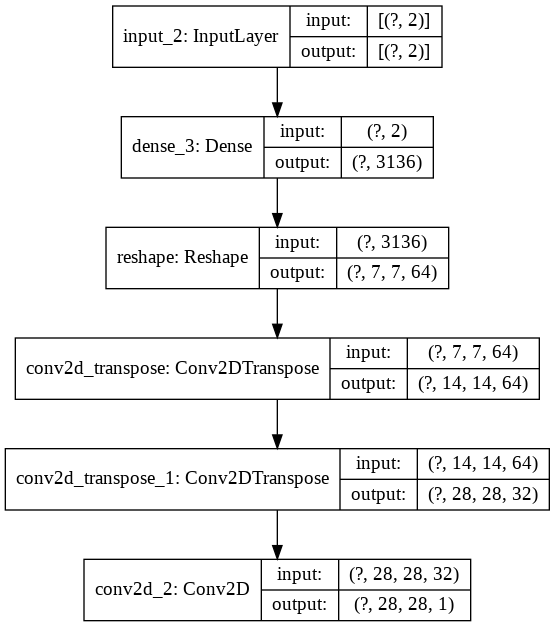

In [0]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [0]:
encoder(input_img)

[<tf.Tensor 'model/Identity:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'model/Identity_1:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'model/Identity_2:0' shape=(None, 2) dtype=float32>]

In [0]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________


In [0]:
np.array([[1,2,3],[6,7,8]]).flatten()

array([1, 2, 3, 6, 7, 8])

In [0]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_1:0", shape=(None,), dtype=float32) Tensor("Reshape_2:0", shape=(None,), dtype=float32)


In [0]:
input_img.shape

TensorShape([None, 28, 28, 1])

In [0]:
input_img1.shape

TensorShape([None])

In [0]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
3750/3750 [==============================] - 17s 4ms/step - loss: 43.7724 - val_loss: 40.2821
Epoch 2/10
3750/3750 [==============================] - 17s 4ms/step - loss: 39.5696 - val_loss: 38.8104
Epoch 3/10
3750/3750 [==============================] - 17s 4ms/step - loss: 38.5440 - val_loss: 37.9868
Epoch 4/10
3750/3750 [==============================] - 17s 4ms/step - loss: 38.0091 - val_loss: 37.7563
Epoch 5/10
3750/3750 [==============================] - 16s 4ms/step - loss: 37.7067 - val_loss: 37.4495
Epoch 6/10
3750/3750 [==============================] - 16s 4ms/step - loss: 37.4528 - val_loss: 37.7592
Epoch 7/10
3750/3750 [==============================] - 16s 4ms/step - loss: 37.2731 - val_loss: 37.4453
Epoch 8/10
3750/3750 [==============================] - 16s 4ms/step - loss: 37.1896 - val_loss: 37.0661
Epoch 9/10
3750/3750 [==============================] - 16s 4ms/step - loss: 37.0995 - val_loss

In [0]:
np.linspace(0.05,0.95,15)

array([0.05      , 0.11428571, 0.17857143, 0.24285714, 0.30714286,
       0.37142857, 0.43571429, 0.5       , 0.56428571, 0.62857143,
       0.69285714, 0.75714286, 0.82142857, 0.88571429, 0.95      ])

In [0]:
norm.ppf([0.025]) # p-에 해당하는, x값을 출력함. 오른쪽 기준. 

array([-1.95996398])

In [0]:
x=0.05 ; y=0.05 ; z_sample = np.array([[x,y]]) ; print(z_sample)

[[0.05 0.05]]


In [0]:
z_sample=np.tile(z_sample,16).reshape(16,2)

In [0]:
z_sample= np.array([[-2.,-2.]])

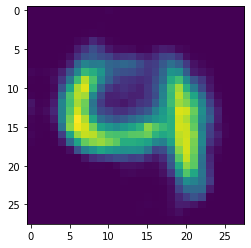

In [0]:
plt.imshow(decoder.predict(z_sample).reshape(28,28))

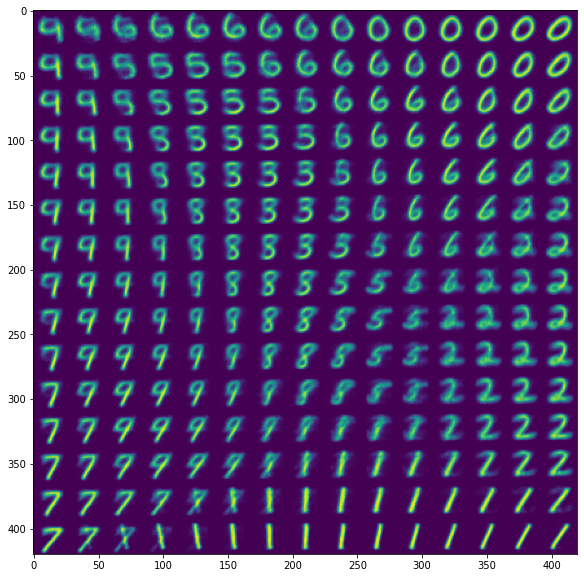

In [0]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n))

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,2) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()


